In [1]:
suppressPackageStartupMessages({

    library(data.table)
    library(ggplot2)
    library(dplyr)
    library(repr)
    library(pheatmap)
    library(irr)
    library(lmerTest)
    library(gridExtra)
    library(pROC)
    library(countsplit)
    library(caret)
    
})

set.seed(42)

### The original data from paper
Reading the count file for microarray data from [This paper](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2001-2-10-research0042) containing 24 samples from 4 mice with two differnt starins and 6 brain regions.



In [2]:
cnt <- fread("../data/Alldatanomef.txt")

gene_ids <- cnt$clone

cnt <- cnt[, 2:25]
cnt <- cnt[, lapply(.SD, as.numeric)]
cnt <- as.matrix(cnt)

rownames(cnt) <- gene_ids

In [3]:
meta <- data.table(region = sub("(\\d+)([A-Za-z]+)\\(.*\\.txt", "\\2", colnames(cnt)),
                    strain = sub("(\\d+)([A-Za-z]+)\\(.*\\.txt", "\\1", colnames(cnt)))
meta[, index := .I]
meta$region <- sub("^B(.*$)", "\\1", meta$region)


cell_line_to_keep <- c("Amygdala", "Cerebellum", "Cortex", "EntorhinalCortex", "Hippocampus", "Midbrain")
meta <- meta[region %in% cell_line_to_keep, ]

Let's see the original raw data to see if it is normalized or needs normalization.

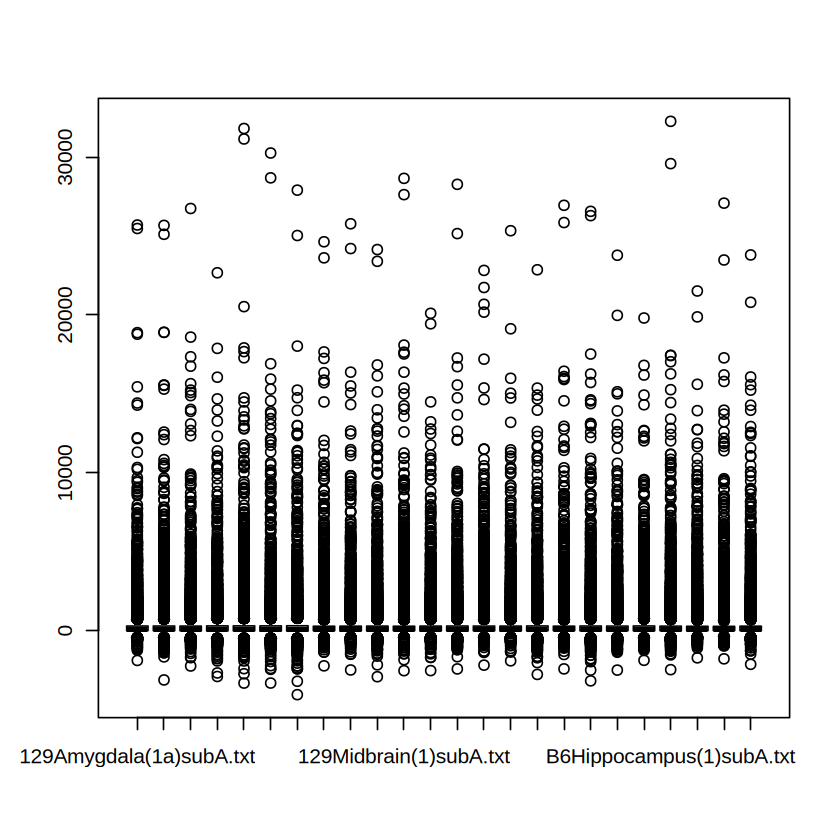

In [4]:
options(repr.plot.width = 7)
boxplot(cnt)

In [6]:
# measuering the varince per each column of raw matrix
var_asses <- apply(cnt, 2, var) %>% as.data.table(keep.rownames = T)
setnames(var_asses, old = c("rn", "."), new = c("og_colnames", "Var"))

# temp meta for variance assessmnet
meta_assess <- meta
meta_assess$og_colnames <- colnames(cnt) 
var_asses <- merge(var_asses, meta_assess, by = "og_colnames")

# converting the region and strain to factor to be used in ggplot2
var_asses$region <- as.factor(var_asses$region)
var_asses$strain <- as.factor(var_asses$strain)

# adding the ID for each cluster
var_asses$mouse <- as.factor(c(rep(c("mc_1", "mc_2"), 6), rep(c("mc_3", "mc_4"), 6)))
meta$mouse <- as.factor(c(rep(c("mc_1", "mc_2"), 6), rep(c("mc_3", "mc_4"), 6)))

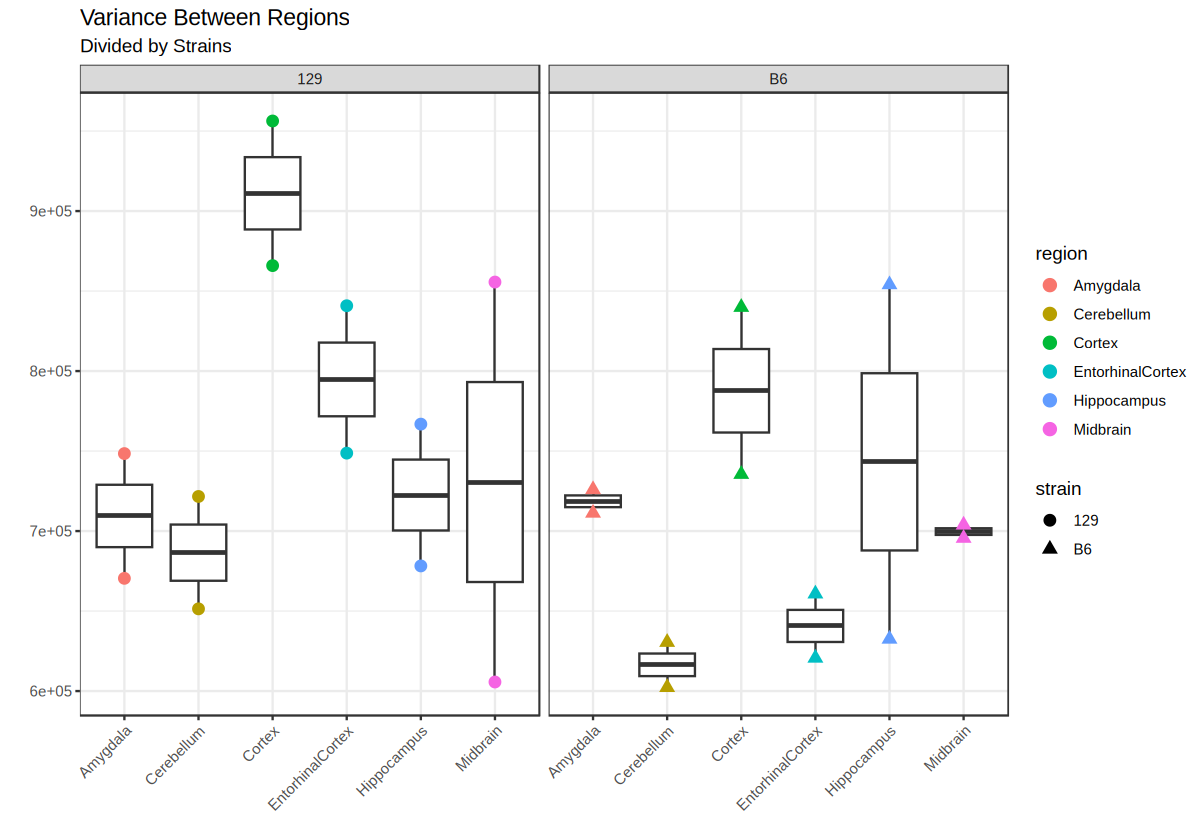

In [7]:
options(repr.plot.height = 7, repr.plot.width = 10)
ggplot(data = var_asses) +
      geom_boxplot(aes(y = Var, x = region)) +  
      geom_point(aes(y = Var, x = region, color = region, shape = strain), size = 3) + 
      labs(title = "Variance Between Regions", subtitle = "Divided by Strains", x = "", y = "") + 
      facet_wrap(~strain) + 
      theme_bw() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))


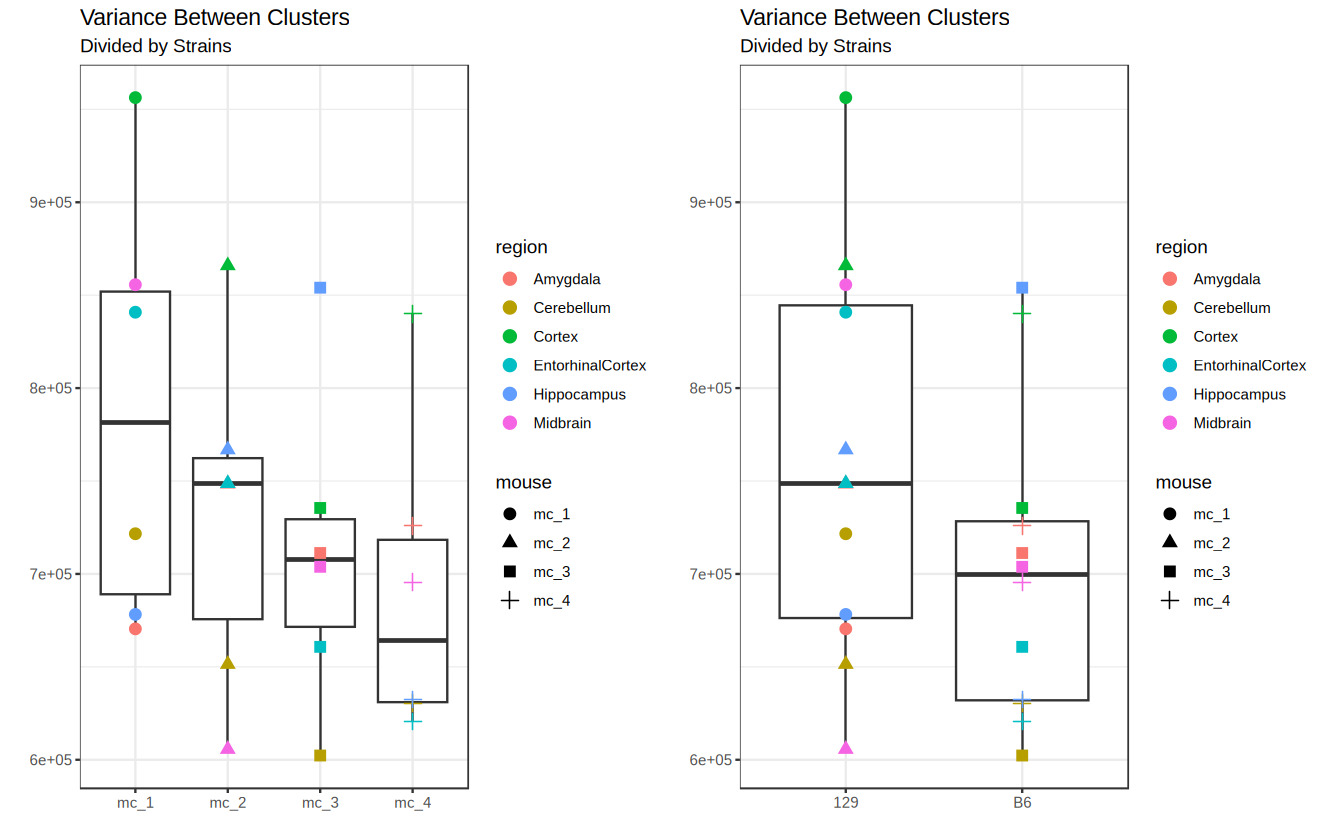

In [8]:
options(repr.plot.height = 7, repr.plot.width = 11)
p1 <- ggplot(data = var_asses) +
      geom_boxplot(aes(y = Var, x = mouse)) +
      geom_point(aes(y = Var, x = mouse, color = region, shape = mouse), size = 3) + 
      labs(title = "Variance Between Clusters", subtitle = "Divided by Strains", x = "", y = "") + 
      theme_bw()

p2 <- ggplot(data = var_asses) +
      geom_boxplot(aes(y = Var, x = strain)) +
      geom_point(aes(y = Var, x = strain, color = region, shape = mouse), size = 3) + 
      labs(title = "Variance Between Clusters", subtitle = "Divided by Strains", x = "", y = "") + 
      theme_bw()


grid.arrange(p1, p2, ncol = 2)

### Making the template for feature selection

In [11]:
test_fun <- function(new_col_name, criteria, target_col_name, metadata) {
  
  # Initiating the column with zeros
  metadata[, (new_col_name) := 0]
  
  # Finding indexes and updating the new column
  sub_indexes <- which(metadata[[target_col_name]] == criteria)
  
  metadata[sub_indexes, (new_col_name) := 1]
  
  return(metadata)
}

In [12]:
test_fun(new_col_name = "starin_temp", criteria = "B6", target_col_name = "strain", metadata = meta)


regions <- unique(meta$region)

# Loop over each region to create binary columns
for (region in regions) {
  column_name <- paste0(region, "_temp")
  meta <- test_fun(column_name, region, "region", meta)
}


In [13]:
meta[c(2,5,6,9,11), ]

region,strain,index,mouse,starin_temp,Amygdala_temp,Cerebellum_temp,Cortex_temp,EntorhinalCortex_temp,Hippocampus_temp,Midbrain_temp
<chr>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Amygdala,129,2,mc_2,0,1,0,0,0,0,0
Cortex,129,5,mc_1,0,0,0,1,0,0,0
Cortex,129,6,mc_2,0,0,0,1,0,0,0
Hippocampus,129,9,mc_1,0,0,0,0,0,1,0
Midbrain,129,11,mc_1,0,0,0,0,0,0,1


#### Strain-specific expression
***
At a p-value cut-off of 10-5, we found about 65 probe sets that show strain-specific variation in expression across all areas, compared to 24 genes showing overall differences between strains identified by Sandberg et al. [1]. The genes near the top of our ranking include many of those chosen by Sandberg [12], and all 24 genes identified by Sandberg et al. have p-values less than 10-3 by either ANOVA, template match, or both. Two examples of strain-specific genes not identified in the previous work are shown in more detail Figure 4a. The first is Sparc/osteonectin (testican), which was detected at lower levels in the C57B16 strain. The second is phosphatase ACP1/ACP2, with the opposite expression pattern. We rank ACP1/ACP2 and Sparc/osteonectin as having the 9th and 23rd strongest strain differences, respectively (both ACP1/ACP2 and Sparc/osteonectin are also shown in Figure 3). For comparison, Figure 4b shows β-globin, which was identified in [1] and was ranked 67th by template match. Overall, we rank 46 previously unrecognized genes as having stronger strain differences than β-globin.

In [14]:
fit_strain_temp <- lapply(1:nrow(cnt), function(gene){fit_summary <- lm(cnt[gene,] ~ meta$starin_temp)})

In [15]:
summary(fit_strain_temp[[2]])


Call:
lm(formula = cnt[gene, ] ~ meta$starin_temp)

Residuals:
     Min       1Q   Median       3Q      Max 
-111.417  -29.167    1.917   33.583   85.583 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       172.750     13.947  12.386 2.16e-11 ***
meta$starin_temp   -7.333     19.724  -0.372    0.714    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 48.31 on 22 degrees of freedom
Multiple R-squared:  0.006244,	Adjusted R-squared:  -0.03893 
F-statistic: 0.1382 on 1 and 22 DF,  p-value: 0.7136


In [16]:
gene_2_dt <- data.table(gene = as.numeric(cnt[2,]), region = factor(meta$region), starin = factor(meta$strain), mouse = meta$mouse)

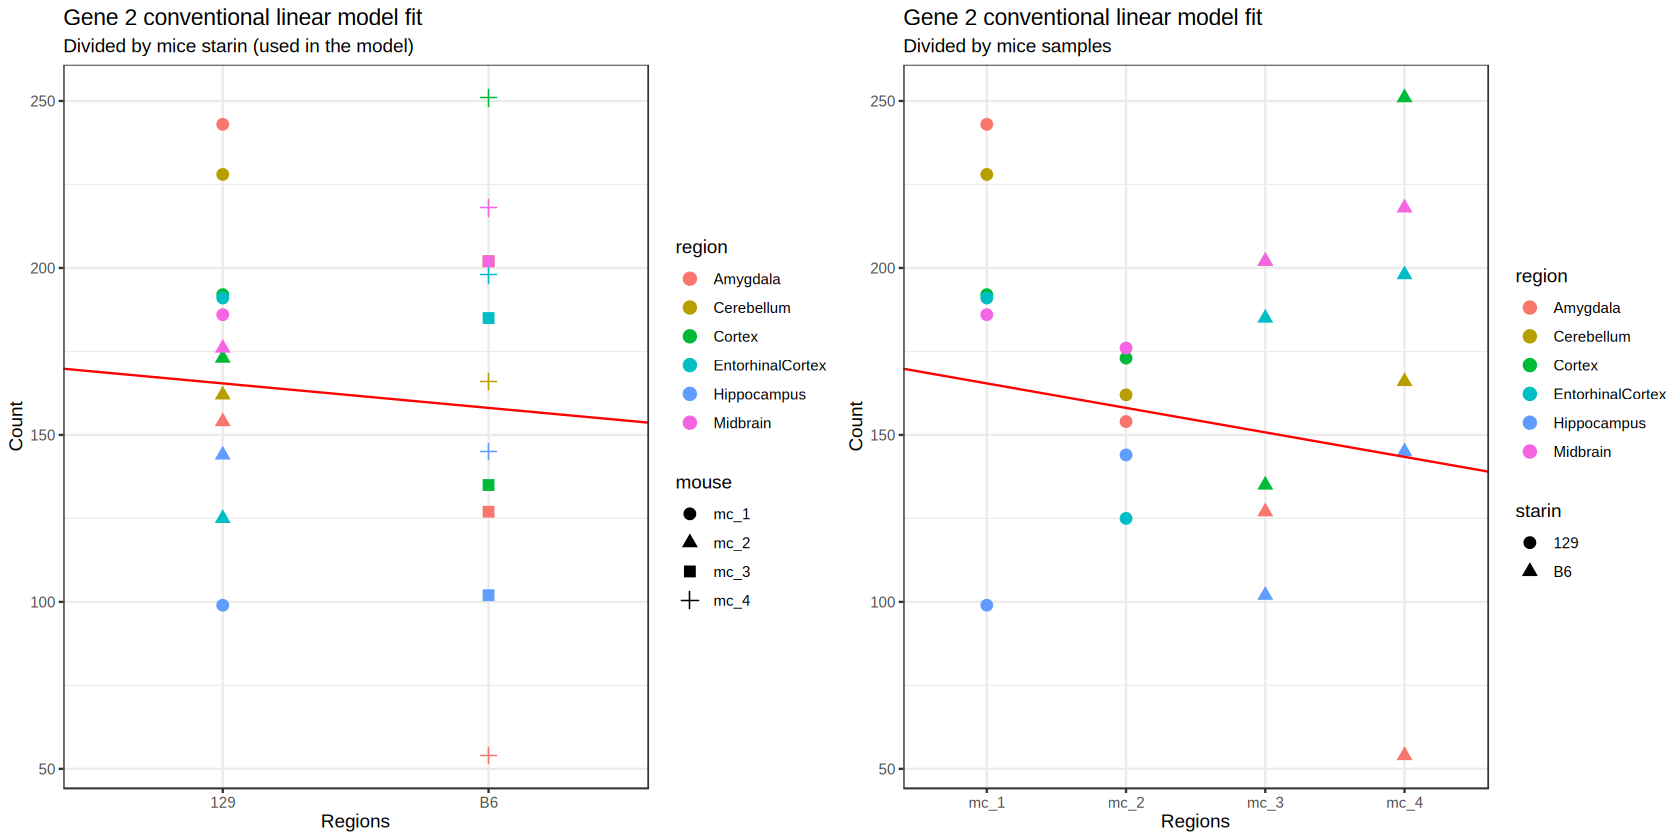

In [17]:
options(repr.plot.height = 7, repr.plot.width = 14)

p1 <- ggplot(gene_2_dt) +
geom_point(aes(x = mouse, y = gene, color = region, shape = starin), size = 3) +
theme_bw() +
geom_abline(slope = -7.333, intercept = 172.750, color = "red") +
labs(x = "Regions", y = "Count", title = "Gene 2 conventional linear model fit", subtitle = "Divided by mice samples")


p2 <- ggplot(gene_2_dt) +
geom_point(aes(x = starin, y = gene, color = region, shape = mouse), size = 3) +
theme_bw() +
geom_abline(slope = -7.333, intercept = 172.750, color = "red") +
labs(x = "Regions", y = "Count", title = "Gene 2 conventional linear model fit", subtitle = "Divided by mice starin (used in the model)")


grid.arrange(p2, p1, ncol = 2)

In [18]:
mixed_effect_model <- lmerTest::lmer(cnt[2,] ~ meta$starin_temp + (meta$starin_temp | meta$mouse))
# summary(mixed_effect_model)
ranef(mixed_effect_model)

boundary (singular) fit: see help('isSingular')



$`meta$mouse`
       (Intercept) meta$starin_temp
mc_1  5.967905e+00    -5.967858e+00
mc_2 -5.967905e+00     5.967858e+00
mc_3 -2.776808e-05     2.774694e-05
mc_4  2.776808e-05    -2.774694e-05

with conditional variances for “meta$mouse” 

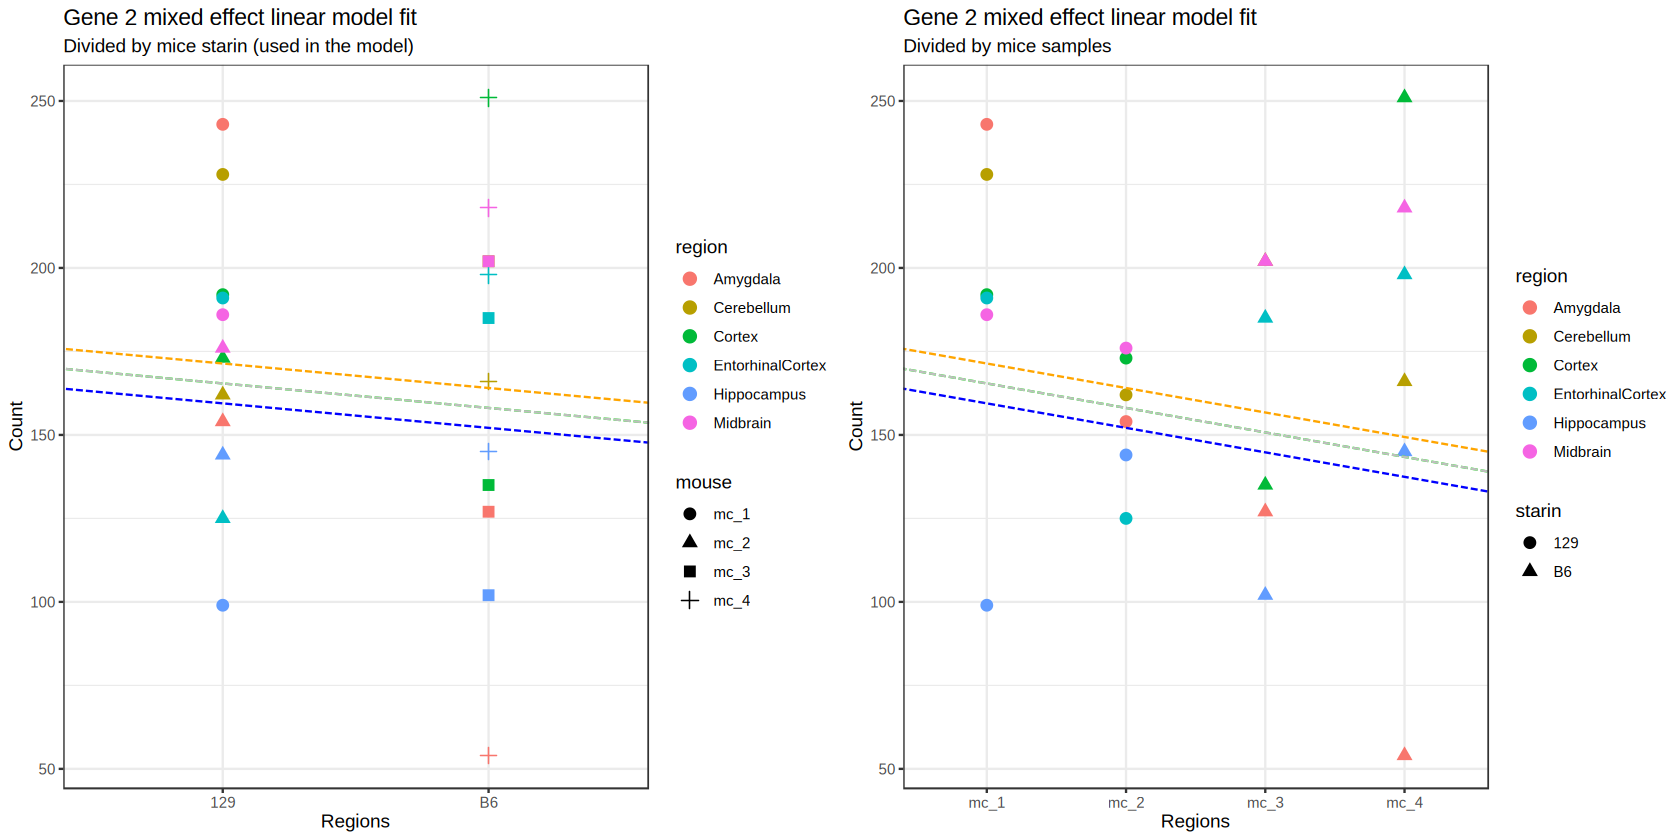

In [19]:
p1 <- ggplot(gene_2_dt) +
geom_point(aes(x = starin, y = gene, color = region, shape = mouse), size = 3) +
theme_bw() +
geom_abline(slope = -7.333 , intercept = 172.750 - 5.967858e+00, color = "blue", linetype = 5) + 
geom_abline(slope = -7.333, intercept = 172.750 + 5.967858e+00, color = "orange", linetype = 5) + 
geom_abline(slope = -7.333, intercept = 172.750 + 2.774694e-05, color = "green", linetype = 5) + 
geom_abline(slope = -7.333, intercept = 172.750 - 2.774694e-05, color = "gray", linetype = 5) + 
labs(x = "Regions", y = "Count", title = "Gene 2 mixed effect linear model fit", subtitle = "Divided by mice starin (used in the model)")



p2 <- ggplot(gene_2_dt) +
geom_point(aes(x = mouse, y = gene, color = region, shape = starin), size = 3) +
theme_bw() +
geom_abline(slope = -7.333 , intercept = 172.750 - 5.967858e+00, color = "blue", linetype = 5) + 
geom_abline(slope = -7.333, intercept = 172.750 + 5.967858e+00, color = "orange", linetype = 5) + 
geom_abline(slope = -7.333, intercept = 172.750 + 2.774694e-05, color = "green", linetype = 5) + 
geom_abline(slope = -7.333, intercept = 172.750 - 2.774694e-05, color = "gray", linetype = 5) + 
labs(x = "Regions", y = "Count", title = "Gene 2 mixed effect linear model fit", subtitle = "Divided by mice samples")



grid.arrange(p1, p2, ncol = 2)

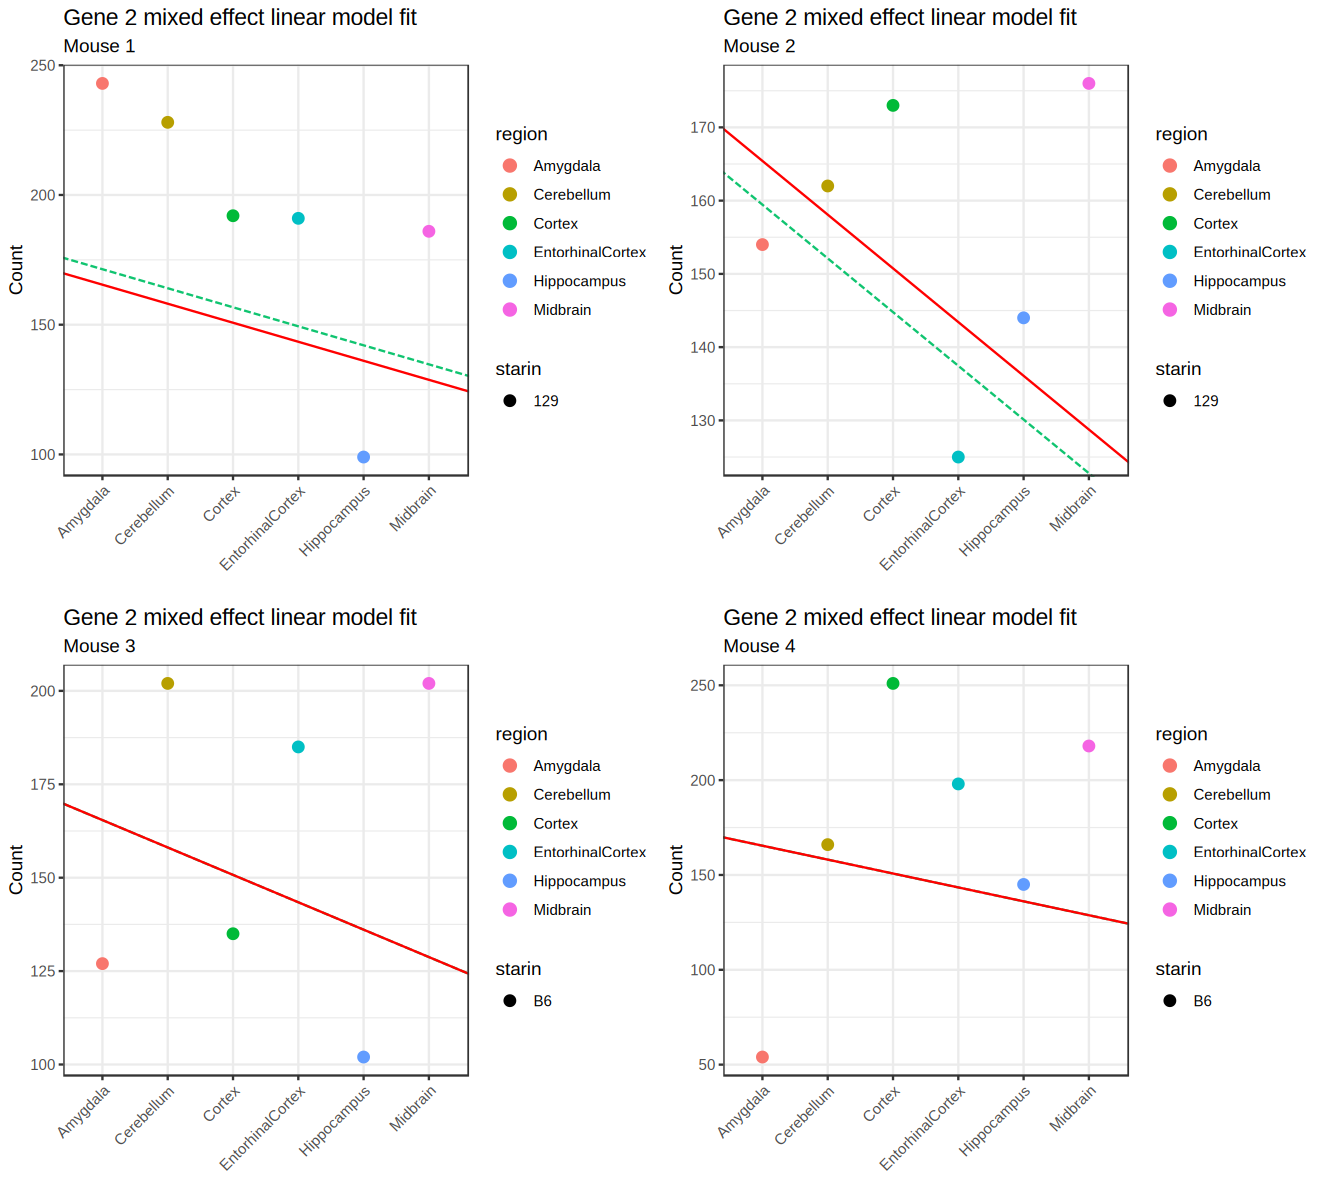

In [22]:
options(repr.plot.height = 10, repr.plot.width = 11)


p1 <- ggplot(gene_2_dt[mouse == "mc_1", ]) +
geom_point(aes(x = region, y = gene, color = region, shape = starin), size = 3) +
theme_bw() + 
geom_abline(slope = -7.333 , intercept = 172.750 + 5.967858e+00, color = "#10c470", linetype = 5)  + 
geom_abline(slope = -7.333 , intercept = 172.750 , color = "red", linetype = 1) + 
labs(x = "", y = "Count", title = "Gene 2 mixed effect linear model fit", subtitle = "Mouse 1") +
theme(axis.text.x = element_text(angle = 45, hjust = 1))



p2 <- ggplot(gene_2_dt[mouse == "mc_2", ]) +
geom_point(aes(x = region, y = gene, color = region, shape = starin), size = 3) +
theme_bw() + 
geom_abline(slope = -7.333 , intercept = 172.750 - 5.967905e+00, color = "#10c470", linetype = 5)  + 
geom_abline(slope = -7.333 , intercept = 172.750 , color = "red", linetype = 1) + 
labs(x = "", y = "Count", title = "Gene 2 mixed effect linear model fit", subtitle = "Mouse 2") +
theme(axis.text.x = element_text(angle = 45, hjust = 1))



p3 <- ggplot(gene_2_dt[mouse == "mc_3", ]) +
geom_point(aes(x = region, y = gene, color = region, shape = starin), size = 3) +
theme_bw() + 
geom_abline(slope = -7.333 , intercept = 172.750 - 2.776808e-05, color = "#10c470", linetype = 5)  + 
geom_abline(slope = -7.333 , intercept = 172.750 , color = "red", linetype = 1) + 
labs(x = "", y = "Count", title = "Gene 2 mixed effect linear model fit", subtitle = "Mouse 3") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))


p4 <- ggplot(gene_2_dt[mouse == "mc_4", ]) +
geom_point(aes(x = region, y = gene, color = region, shape = starin), size = 3) +
theme_bw() + 
geom_abline(slope = -7.333 , intercept = 172.750 + 2.776808e-05, color = "#10c470", linetype = 5)  + 
geom_abline(slope = -7.333 , intercept = 172.750 , color = "red", linetype = 1) + 
labs(x = "", y = "Count", title = "Gene 2 mixed effect linear model fit", subtitle = "Mouse 4") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))


grid.arrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

In [28]:
p_values_strain_temp <- sapply(fit_strain_temp, function(fit) summary(fit)$coefficients[2, 4])

In [14]:
r_squ_strain_temp <- sapply(fit_strain_temp, function(fit) summary(fit)$r.squared)

In [15]:
assess_df <- data.table(p_val = p_values_strain_temp, 
                       r_squ = r_squ_strain_temp,
                       features = as.factor(rownames(cnt)))

In [16]:
temp_res <- data.table(genes = rownames(cnt), p_val = p_values_strain_temp)
temp_res <- temp_res[p_val < 1e-5, ]

In [17]:
selected_genes <- temp_res[order(p_val), ] 

In [18]:
index_cnt <- which(rownames(cnt) %in% selected_genes$genes)
cnt_temp <- cnt[index_cnt, ]

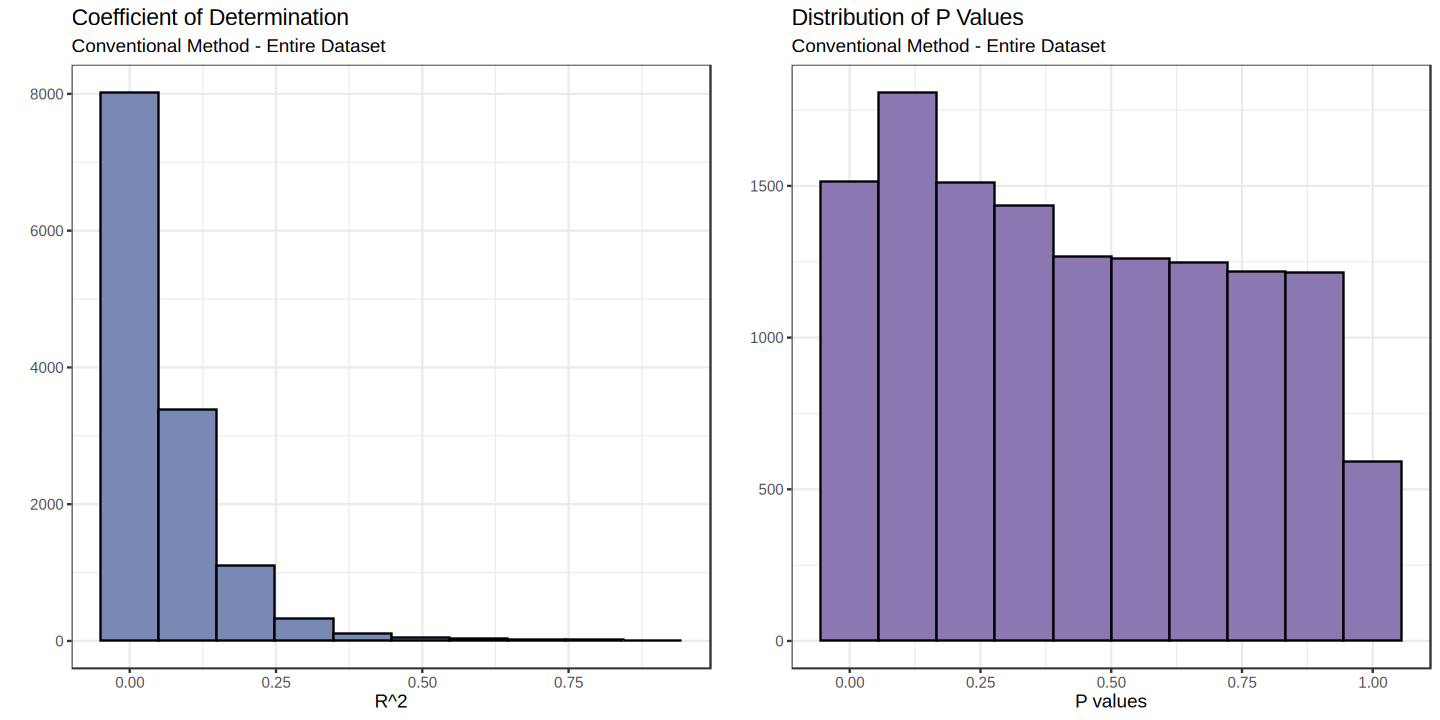

In [19]:
options(repr.plot.height = 6, repr.plot.width = 12)

p1 <- ggplot(data =NULL) +
        geom_histogram(aes(x = r_squ_strain_temp), bins = 10, color = "black", fill = "#788ab3") +
        theme_bw() +
        labs(x = "R^2", y = "", title = "Coefficient of Determination", subtitle = "Conventional Method - Entire Dataset")


p2 <- ggplot(data = NULL) +
        geom_histogram(aes(x = p_values_strain_temp), bins = 10, color = "black", fill = "#8b78b3") +
        theme_bw() +
        labs(x = "P values", y = "", title = "Distribution of P Values", subtitle = "Conventional Method - Entire Dataset")


grid.arrange(p1, p2, ncol = 2)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


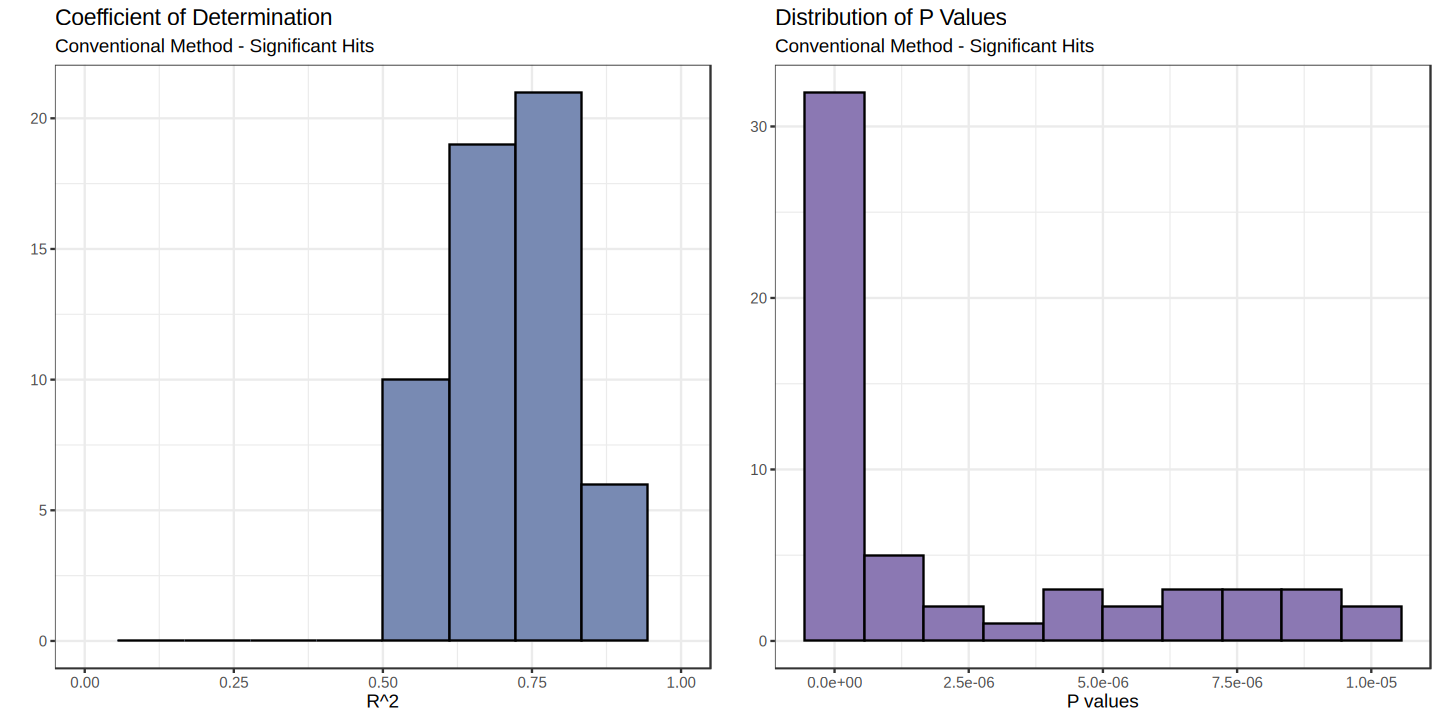

In [24]:
p1 <- ggplot(data = assess_df[index_cnt, ]) +
geom_histogram(aes(x = r_squ), bins = 10, color = "black", fill = "#788ab3") +
theme_bw() +
labs(x = "R^2", y = "", title = "Coefficient of Determination", subtitle = "Conventional Method - Significant Hits") +
xlim(c(0,1))



p2 <- ggplot(data = assess_df[index_cnt, ]) +
geom_histogram(aes(x = p_val), bins = 10, color = "black", fill = "#8b78b3") +
theme_bw() +
labs(x = "P values", y = "", title = "Distribution of P Values", subtitle = "Conventional Method - Significant Hits")
grid.arrange(p1, p2, ncol = 2)

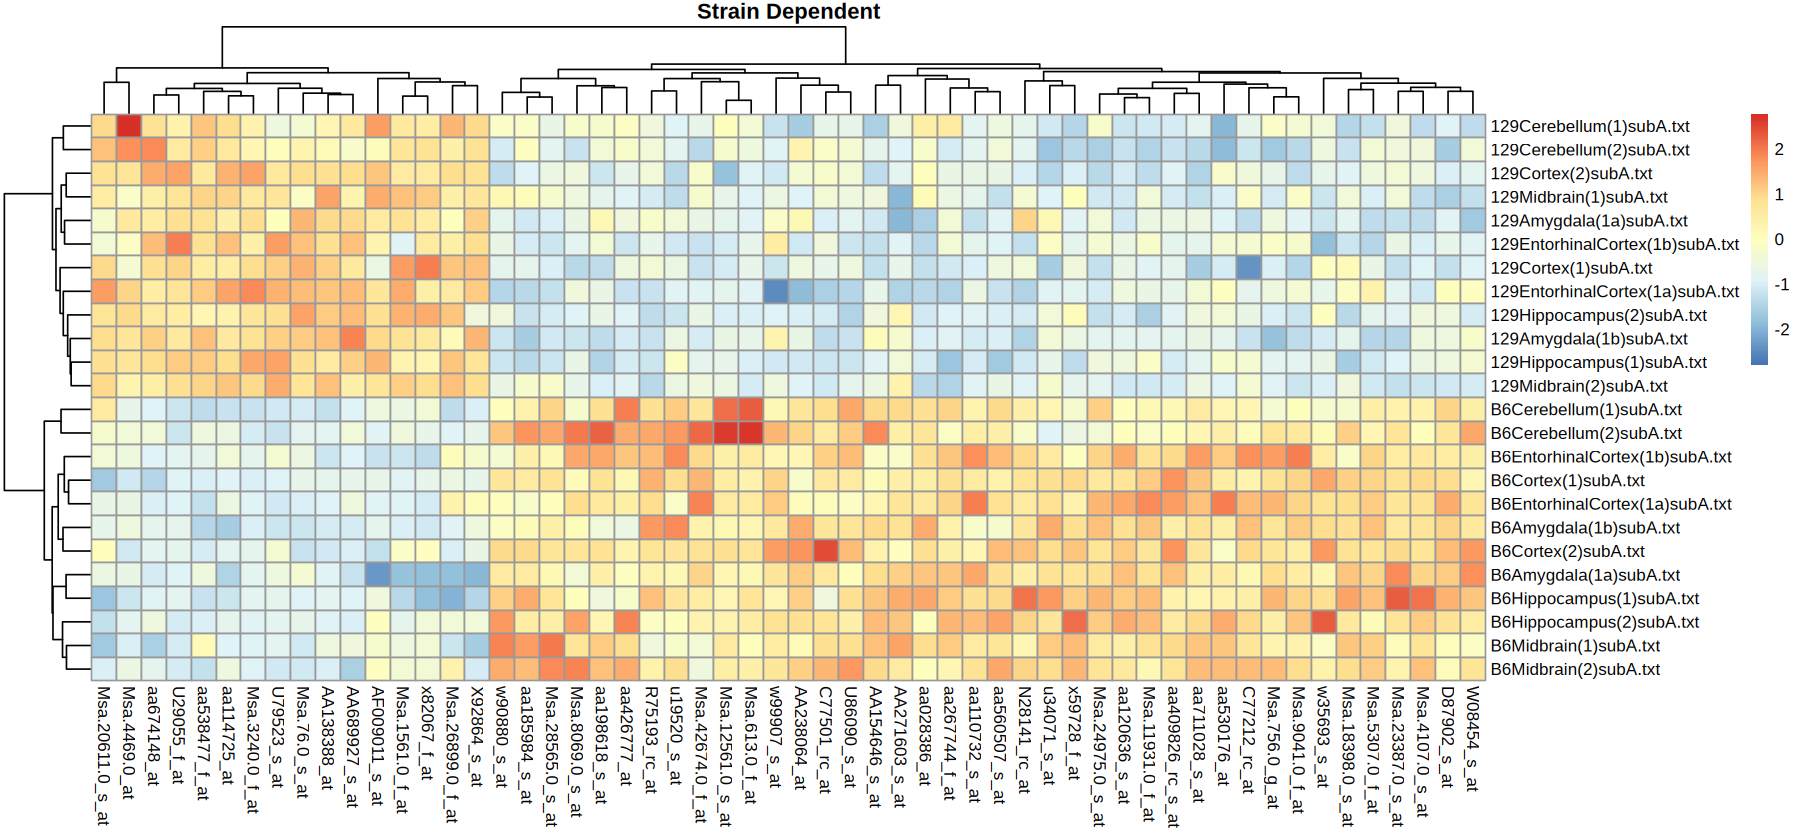

In [25]:
options(repr.plot.height = 7, repr.plot.width = 15)
pheatmap(t(cnt_temp), scale = "column", main = "Strain Dependent")

The dataset of Sandberg et al. [1] consists of duplicate analysis of six brain regions (**amygdala, cerebellum, cortex, entorhinal cortex, hippocampus and midbrain**) in two strains of mice (129SvEv and C57BL/6), for 13,067 genes and ESTs. We performed two-factor ANOVA and feature selection to look for strain- and/or region-specific variation in gene expression in this data. Our feature-selection strategy, which we call 'template matching', is depicted schematically in Figure 1.

## Mixed effect models
**Hint**:This step might took a while, somewhere between 1-30 minutes depending on your compute power.

In [23]:
suppressWarnings({
    suppressMessages({

        # the random effect is so small, that's why we are getting the `boundary (singular) fit: see help('isSingular')` message
        fit_starin_temp_MEM <- lapply(1:nrow(cnt), function(gene){fit_summary <- lmerTest::lmer(cnt[gene,] ~ meta$starin_temp + (meta$starin_temp | meta$mouse))}) 
})
    })

In [24]:
p_values_fit_starin_temp_MEM <- sapply(fit_starin_temp_MEM, function(fit) summary(fit)$coefficients[2, 5])

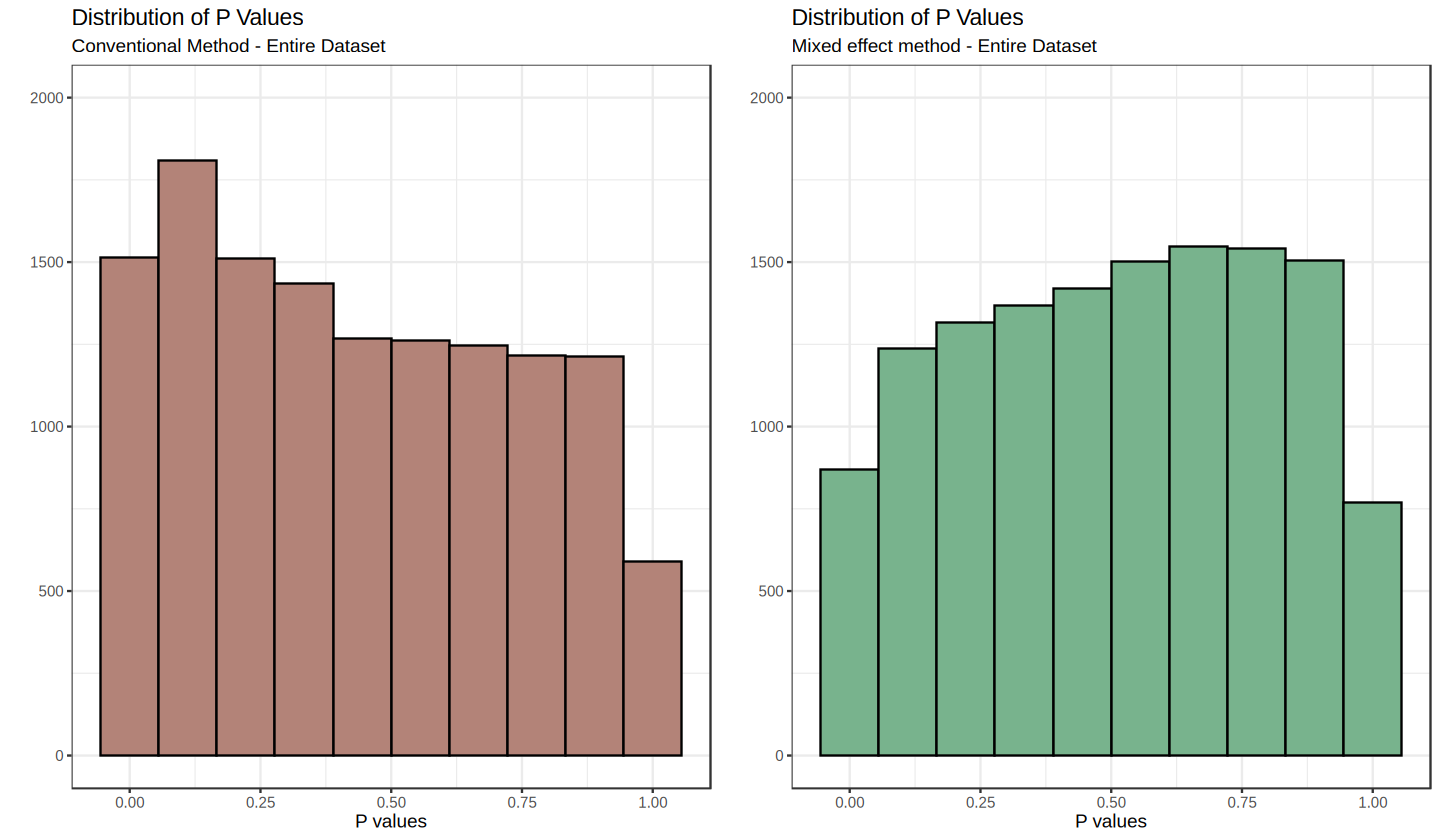

In [33]:
options(repr.plot.height = 7, repr.plot.width = 12)

p1 <- ggplot(data =NULL) +
        geom_histogram(aes(x = p_values_strain_temp), bins = 10, color = "black", fill = "#b38378") +
        theme_bw() +
        labs(x = "P values", y = "", title = "Distribution of P Values", subtitle = "Conventional Method - Entire Dataset") +
        ylim(c(0, 2000))



p2 <- ggplot(data = NULL) +
geom_histogram(aes(x = p_values_fit_starin_temp_MEM), bins = 10, color = "black", fill = "#78b38d") +
theme_bw() +
labs(x = "P values", y = "", title = "Distribution of P Values", subtitle = "Mixed effect method - Entire Dataset") + 
ylim(c(0, 2000))


grid.arrange(p1, p2, ncol = 2)

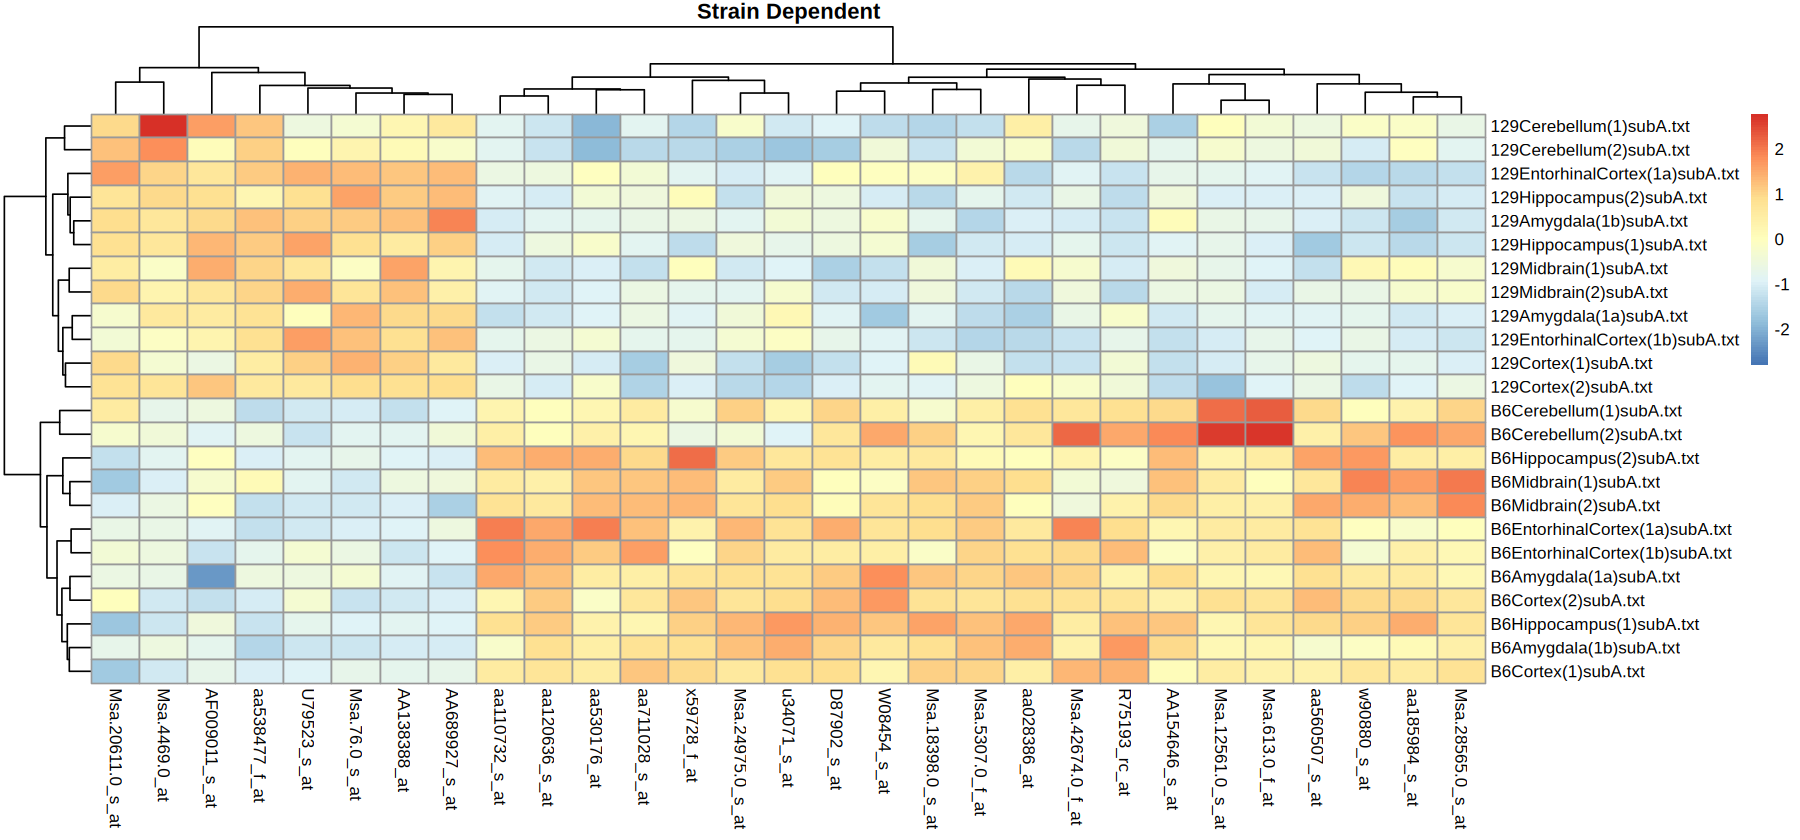

In [35]:
temp_res <- data.table(genes = rownames(cnt), p_val = p_values_fit_starin_temp_MEM)
temp_res <- temp_res[p_val < 1e-5, ]

selected_genes <- temp_res[order(p_val), ] 

index_cnt <- which(rownames(cnt) %in% selected_genes$genes)
cnt_temp <- cnt[index_cnt, ]

options(repr.plot.height = 7, repr.plot.width = 15)
pheatmap(t(cnt_temp), scale = "column", main = "Strain Dependent")

In [286]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: FlexiBLAS IMKL;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] caret_6.0-94       lattice_0.21-8     countsplit_4.0.0   pROC_1.18.5       
 [5] performance_0.12.4 gridExtra_2.3      lmerTest_3.1-3     lme4_1.1-35.3     
 [9] Matrix_1.6-5       irr_0.84.1         lpSolve_5.6.21     pheatmap_1.0.12   
[13] repr_1.1.7         dpl